# Description
---

This notebook can be used to reproduce results form the paper:
"Cross-column DFT-based QSRR model development powered by Machine Learning".

Data (molecular descriptors, column characteristics, and experimental retention times) are loaded, split into training, validation and blind test. QSRR models are built using four ML methods (Ridge Regression, Partial Least Squares, Random Forests and Gradient Boosting). Hyperparameters of the ML QSRR models are optimized using a grid search.

# Requirements
---

1. jupyter
2. notebook
3. numpy
4. pandas
5. matplotlib
6. seaborn
7. scikit-learn
8. shap

# Imports
---

In [1]:
# Install requirements
%pip install numpy pandas matplotlib seaborn scikit-learn shap

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
from copy import deepcopy
from typing import (
    Any,
    Dict,
    List
)

import numpy as np
from numpy import ndarray

import pandas as pd
from pandas import DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    PredefinedSplit,
    train_test_split
)

In [3]:
# Place the package on the path

QSRR_PATH: str = os.path.join(os.path.dirname(os.getcwd()))

if QSRR_PATH not in sys.path:
    sys.path.insert(0, QSRR_PATH)

In [4]:
from qsrr.analysis import analyze_model
from qsrr.config import (
    plot_settings,
    project1_split_indices
)
from qsrr.visuals import Visualizer

plt.rcParams.update(plot_settings)

sns.set()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Loading & Processing
---

In [5]:
# Load Data
_data_df: DataFrame = pd.read_csv(
    '../data/2023-07-19-qsrr_dataset.csv'
)

# Drop columns= 'name' and '#', 'ID', "Length"
_data_df.drop(
    columns=['#','name', 'ID', "Length"],
    errors="ignore",
    inplace=True
)

# Display Data
display(_data_df.head())

,SE[kcal/mol],Delta(min)[eV],M(tot.)[D],EnergyGap[eV],Electrophilicity[eV],IP[eV],EA[eV],GlobalHardness[eV],Electronegativity[eV],Electrophilicity [eV],Temperature,Gradient,ParticleSize,Carbon Load,PoreSize,TR
0,-7.440,-0.503,5.3780,8.383,-3.93,8.12,-0.26,4.19,3.93,1.84,25,40,2.7,10,120,15.842
1,-6.145,-0.545,1.7540,7.810,-3.61,7.51,-0.30,3.90,3.61,1.67,25,40,2.7,10,120,30.996
2,-7.669,-0.679,2.4686,8.287,-3.68,7.82,-0.46,4.14,3.68,1.63,25,40,2.7,10,120,12.111
3,-9.395,-0.666,6.9915,9.167,-4.07,8.65,-0.52,4.58,4.07,1.81,25,40,2.7,10,120,4.968
4,-12.792,-0.680,3.8255,7.723,-2.63,6.49,-1.23,3.86,2.63,0.90,25,40,2.7,10,120,12.465


# Data Analysis
---

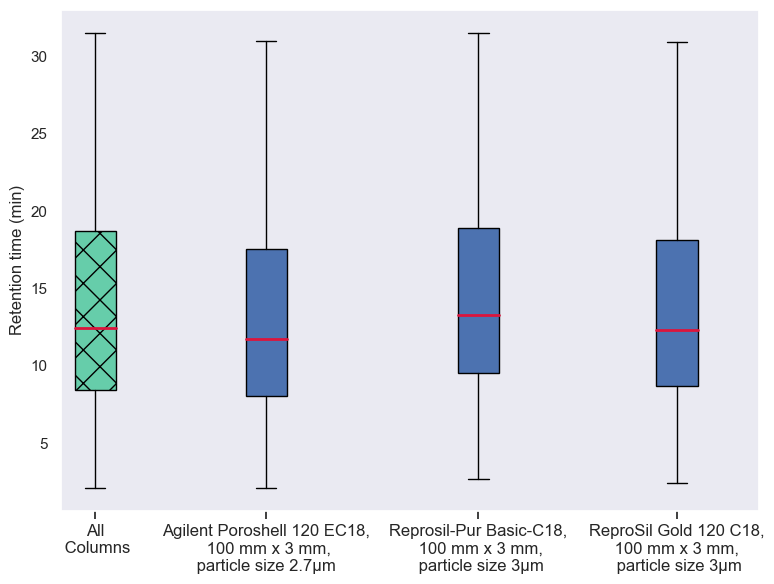

In [6]:
# Retention Times Boxplot

_x: List[Any] = [
    _data_df['TR'],
    _data_df['TR'][_data_df['Carbon Load'] == 10],  # Column 1
    _data_df['TR'][_data_df['Carbon Load'] == 17],  # Column 2
    _data_df['TR'][_data_df['Carbon Load'] == 20]
]

_positions: List[int] = [5, 30, 61, 90]

_labels: List[str] = [
    'All\n Columns',
    'Agilent Poroshell 120 EC18,\n 100 mm x 3 mm,\n particle size 2.7μm ',
    'Reprosil-Pur Basic-C18,\n 100 mm x 3 mm,\n particle size 3μm',
    'ReproSil Gold 120 C18,\n 100 mm x 3 mm, \n particle size 3μm'
]

_y_label: str = 'Retention time (min)'

Visualizer.boxplot(
    x=_x,
    positions=_positions,
    labels=_labels,
    y_label=_y_label
)

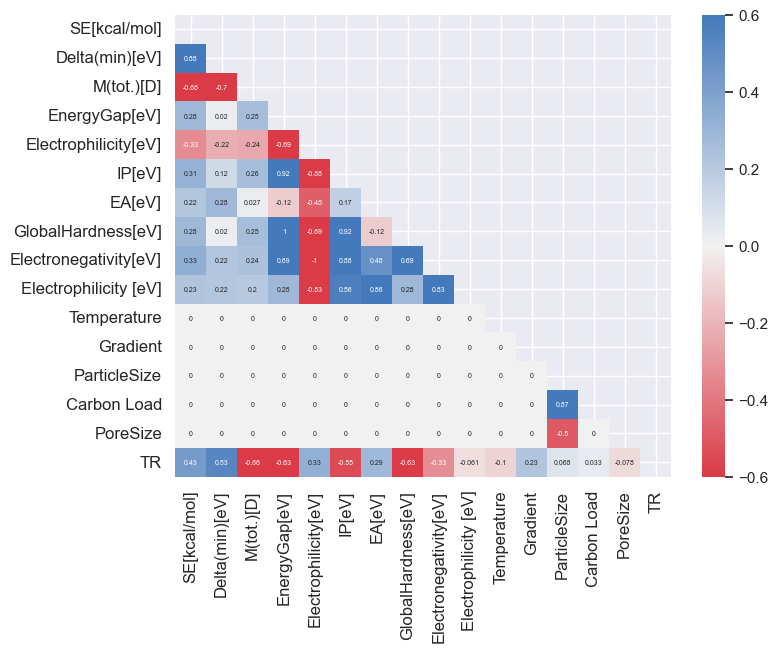

In [7]:
# Correlation Matrix Plot
_correlation_df = _data_df.corr(method='spearman')

Visualizer.correlation_heatmap(
    _correlation_df
)

# Train/Test Split

In [8]:
# X- and y- data
_x: ndarray = _data_df.iloc[:,:-1].values  # Variables -> x1 to x15
_y: ndarray = _data_df.iloc[:,-1].values   # Target: -> tR : retention tiime

# Split initial data into training & blind test sets
_x_train_all, _x_bt, _y_train_all, _y_bt = train_test_split(
    _x,
    _y,
    test_size=0.3
    ,shuffle=True,
    random_state=12345  # For reproducibility
)

# Split the training data further into training and validation
_x_train, _x_validation, _y_train, _y_validation = train_test_split(
    _x_train_all,
    _y_train_all,
    test_size=0.3,
    random_state=12345   # For reproducibility
)

# Summary
print('X-train:', _x_train.shape)
print('y-train:', _y_train.shape)
print('- - '*10)
print('X-validation:', _x_validation.shape)
print('y-validation:', _y_validation.shape)
print('- - '*10)
print('X-BT:', _x_bt.shape)
print('y-BT:', _y_bt.shape)
print('- - '*10)

# Using Predefiend Set of data for validation for hyper-parameter optimization
ps = PredefinedSplit(test_fold=project1_split_indices)

X-train: (176, 15)
y-train: (176,)
- - - - - - - - - - - - - - - - - - - - 
X-validation: (76, 15)
y-validation: (76,)
- - - - - - - - - - - - - - - - - - - - 
X-BT: (108, 15)
y-BT: (108,)
- - - - - - - - - - - - - - - - - - - - 


# Hyper-Parameter Optimization, QSRR model building & analysis
---

## Random Forests
---

In [9]:
# RFs parameter grid
_rfs_param_grid: Dict[str, Any] = {
    'n_estimators': range(10, 210, 10),
    'max_features': [None, 'sqrt'],
    'max_depth': range(2, 30, 3),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False]
}

In [10]:
# Instantiate model
_rfs_model: GridSearchCV = GridSearchCV(
    estimator=RandomForestRegressor(random_state=12345),
    param_grid=_rfs_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=ps,
    n_jobs=20,
    verbose=10,
    refit=True
)

In [11]:
# Fit model
_rfs_model.fit(
    deepcopy(_x_train_all),  # Use all, because we extracted the validation indices previously for reproducibility
    deepcopy(_y_train_all)   # Use all, because we extracted the validation indices previously for reproducibility
)

Fitting 1 folds for each of 7200 candidates, totalling 7200 fits
[CV 1/1; 2/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20
[CV 1/1; 2/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=-3.258 total time=   0.1s
[CV 1/1; 23/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30
[CV 1/1; 23/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30;, score=-3.224 total time=   0.2s
[CV 1/1; 26/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60
[CV 1/1; 26/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60;, score=-3.250 total time=   0.2s
[CV 1/1; 30/7200] START bootstrap=True, max_depth=2, max_features=N

[CV 1/1; 884/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=40
[CV 1/1; 884/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=40;, score=-1.092 total time=   0.2s
[CV 1/1; 894/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 894/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140;, score=-1.095 total time=   0.5s
[CV 1/1; 921/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10
[CV 1/1; 921/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=-1.325 total time=   0.0s
[CV 1/1; 923/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_es

[CV 1/1; 785/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=-0.815 total time=   0.1s
[CV 1/1; 792/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 792/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=-0.822 total time=   0.5s
[CV 1/1; 819/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=190
[CV 1/1; 819/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=190;, score=-0.830 total time=   0.6s
[CV 1/1; 856/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=160
[CV 1/1; 856/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estim

[CV 1/1; 235/7200] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=-3.542 total time=   0.4s
[CV 1/1; 260/7200] START bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200
[CV 1/1; 260/7200] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=-3.539 total time=   0.6s
[CV 1/1; 296/7200] START bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=160
[CV 1/1; 296/7200] END bootstrap=True, max_depth min_samples_leaf=3, min_samples_split=2, n_estimators=90;, score=-3.589 total time=   0.3s
[CV 1/1; 267/7200] START bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=70
[CV 1/1; 267/7200] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=70;, score=-3.5

[CV 1/1; 631/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=110
[CV 1/1; 631/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=110;, score=-2.188 total time=   0.3s
[CV 1/1; 652/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=120
[CV 1/1; 652/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=120;, score=-2.289 total time=   0.3s
[CV 1/1; 670/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100
[CV 1/1; 670/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-2.401 total time=   0.3s
[CV 1/1; 691/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_

[CV 1/1; 651/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=110
[CV 1/1; 651/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=110;, score=-2.291 total time=   0.3s
[CV 1/1; 675/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=150
[CV 1/1; 675/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=150;, score=-2.435 total time=   0.4s
[CV 1/1; 702/7t, min_samples_leaf=1, min_samples_split=5, n_estimators=60
[CV 1/1; 566/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60;, score=-1.906 total time=   0.2s
[CV 1/1; 577/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170
[CV 1/1; 577/7200] END bootstrap=True, max_

[CV 1/1; 699/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=190;, score=-2.371 total time=   0.6s
[CV 1/1; 735/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 1/1; 735/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-0.498 total time=   0.6s
[CV 1/1; 765/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 1/1; 765/7200] END bootstrap=True, max_deptures=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=80;, score=-2.234 total time=   0.2s
[CV 1/1; 642/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20
[CV 1/1; 642/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20;, s

[CV 1/1; 800/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=200
[CV 1/1; 800/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=-0.832 total time=   0.7s
[CV 1/1; 838/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180
[CV 1/1; 838/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-0.971 total time=   0.6s
[CV 1/1; 872/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120
[CV 1/1; 872/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120;, score=-1.095 total time=   0.4s
[CV 1/1; 891/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=10, n

[CV 1/1; 953/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130;, score=-2.049 total time=   0.4s
[CV 1/1; 976/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=160
[CV 1/1; 976/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-2.076 total time=   0.5s
[CV 1/1; 1005/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/1; 1005/7200] END bootstrap=True, max_depth=8, max_features=sqrt, 3, min_samples_split=10, n_estimators=140
[CV 1/1; 474/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=140;, score=-1.013 total time=   0.4s
[CV 1/1; 498/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=180
[

[CV 1/1; 1021/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=-1.729 total time=   0.0s
[CV 1/1; 1025/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50
[CV 1/1; 1025/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-2.100 total time=   0.2s
[CV 1/1; 1036/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=160
[CV 1/1; 1036/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=160;, score=-2.280 total time=   0.5s
tures=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=-1.934 total time=   0.3s
[CV 1/1; 595/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 1/1; 59

[CV 1/1; 1111/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=110
[CV 1/1; 1111/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=-0.671 total time=   0.4s
[CV 1/1; 1128/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 1/1; 1128/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=-0.985 total time=   0.3s
[CV 1/1; 1144/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=40
[CV 1/1; 1144/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-0.821 total time=   0.1s
[CV 1/1; 1153/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_s

[CV 1/1; 1152/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=-0.822 total time=   0.4s
[CV 1/1; 1173/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130
[CV 1/1; 1173/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130;, score=-0.833 total time=   0.4s
[CV 1/1; 1197/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_sampl[CV 1/1; 1060/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=200
[CV 1/1; 1060/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=-2.220 total time=   0.6s
[CV 1/1; 1094/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=140
[CV 

[CV 1/1; 1346/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 1346/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=60;, score=-2.096 total time=   0.2s
[CV 1/1; 1359/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=190
[CV 1/1; 1359/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=190;, score=-2.021 total time=   0.6s
[CV 1/1; 1395/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=150
[CV 1/1; 1395/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=150;, score=-2.284 total time=   0.5s
[CV 1/1; 1421/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_s

[CV 1/1; 1392/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 1/1; 1392/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=-2.257 total time=   0.4s
[CV 1/1; 1414/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=140
[CV 1/1; 1414/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=140;, score=-2.290 total time=   0.5s
[CV 1/1; 1444/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=40
[CV 1/1; 1444/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=-0.503 total time=   0.2s
[CV 1/1; 1454/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_s

[CV 1/1; 1543/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=30
[CV 1/1; 1543/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=30;, score=-1.000 total time=   0.1s
[CV 1/1; 1551/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=110
[CV 1/1; 1551/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=110;, score=-0.961 total time=   0.3s
[CV 1/1; 1567/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=70
[CV 1/1; 1567/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=70;, score=-1.090 total time=   0.2s
[CV 1/1; 1580/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples

[CV 1/1; 1612/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=-1.095 total time=   0.5s
[CV 1/1; 1634/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140
[CV 1/1; 1634/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140;, score=-1.487 total time=   0.4s
[CV 1/1; 1655/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150
[CV 1/1; 1655/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150;, score=-1.644 total time=   0.3s
[CV 1/1; 1672/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=120
[CV 1/1; 1672/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples

[CV 1/1; 1388/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=-2.187 total time=   0.3s
[CV 1/1; 1402/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=20
[CV 1/1; 1402/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=20;, score=-1.990 total time=   0.1s
[CV 1/1; 1408/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 1/1; 1408/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=-2.187 total time=   0.3s
[CV 1/1; 1420/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=200
[CV 1/1; 1420/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=

[CV 1/1; 1779/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=190
[CV 1/1; 1779/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=190;, score=-2.239 total time=   0.3s
[CV 1/1; 1795/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150
[CV 1/1; 1795/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150;, score=-2.284 total time=   0.2s
[CV 1/1; 1805/7200] START bootstrap=True, max_depth=17, maxs=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-2.071 total time=   0.4s
[CV 1/1; 2076/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=160
[CV 1/1; 2076/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split

[CV 1/1; 1415/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=150;, score=-2.284 total time=   0.4s
[CV 1/1; 1438/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=180
[CV 1/1; 1438/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=180;, score=-2.243 total time=   0.6s
[CV 1/1; 1469/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=90
[CV 1/1; 1469/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=90;, score=-0.677 total time=   0.3s
[CV 1/1; 1488/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 1/1; 1488/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_s

[CV 1/1; 1571/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=110;, score=-1.099 total time=   0.3s
[CV 1/1; 1587/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=70
[CV 1/1; 1587/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=70;, score=-1.090 total time=   0.3s
[CV 1/1; 1602/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=20
[CV 1/1; 1602/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=20;, score=-1.239 total time=   0.1s
[CV 1/1; 1606/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=60
[CV 1/1; 1606/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_spl

[CV 1/1; 1350/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=-2.067 total time=   0.3s
[CV 1/1; 1367/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=70
[CV 1/1; 1367/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=70;, score=-1.987 total time=   0.3s
[CV 1/1; 1384/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_es[CV 1/1; 1257/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=170
[CV 1/1; 1257/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=170;, score=-1.095 total time=   0.6s
[CV 1/1; 1288/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n

[CV 1/1; 1161/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=10;, score=-0.961 total time=   0.0s
[CV 1/1; 1162/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=20
[CV 1/1; 1162/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=20;, score=-0.920 total time=   0.1s
[CV 1/1; 1166/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 1166/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60;, score=-0.818 total time=   0.2s
[CV 1/1; 1179/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=190
[CV 1/1; 1179/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=

[CV 1/1; 2185/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 1/1; 2185/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=-0.697 total time=   0.1s
[CV 1/1; 2191/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=110
[CV 1/1; 2191/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=otstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=110
[CV 1/1; 1431/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=110;, score=-2.251 total time=   0.3s
[CV 1/1; 1452/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 1/1; 1452/7200] END bootstrap=True, max_depth=14, m

[CV 1/1; 1564/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=40;, score=-1.092 total time=   0.2s
[CV 1/1; 1575/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=150
[CV 1/1; 1575/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=150;, score=-1.097 total time=   0.5s
[CV 1/1; 1600/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200
[CV 1/1; 1600/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=-1.095 total time=   0.7s
[CV 1/1; 1635/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 1/1; 1635/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_sp

[CV 1/1; 1735/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=-2.096 total time=   0.2s
[CV 1/1; 1739/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=190
[CV 1/1; 1739/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=190;, score=-2.056 total time=   0.2s
[CV 1/1; 1747/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=70
[CV 1/1; 1747/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=70;, score=-2.168 total time=   0.1s
[CV 1/1; 1751/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=110
[CV 1/1; 1751/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_

[CV 1/1; 2079/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=190
[CV 1/1; 2079/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=190;, score=-2.021 total time=   0.4s
[CV 1/1; 2101/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10
[CV 1/1; 2101/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=-1.729 total time=   0.0s
[CV 1/1; 2102/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=20
[CV 1/1; 2102/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=20;, score=-1.990 total time=   0.0s
[CV 1/1; 2104/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_spl

[CV 1/1; 1558/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-0.971 total time=   0.6s
[CV 1/1; 1591/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=110
[CV 1/1; 1591/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=110;, score=-1.099 total time=   0.4s
[CV 1/1; 1614/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 1614/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140;, score=-1.095 total time=   0.5s
[CV 1/1; 1633/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=130
[CV 1/1; 1633/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_sample

[CV 1/1; 2285/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-1.102 total time=   0.1s
[CV 1/1; 2290/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100
[CV 1/1; 2290/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-1.094 total time=   0.2s
[CV 1/1; 2301/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10
[CV 1/1; 2301/7200] END bootstrap=True, man_estimators=50
[CV 1/1; 2125/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=-2.100 total time=   0.1s
[CV 1/1; 2132/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=120
[CV 1/1; 2132/7200] END bootstrap=True, max_depth=1

[CV 1/1; 1891/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=110;, score=-0.820 total time=   0.3s
[CV 1/1; 1906/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=60
[CV 1/1; 1906/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=60;, score=-0.970 total time=   0.1s
[CV 1/1; 1915/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 1915/7200] END bootstrap=True, mares=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=190;, score=-1.611 total time=   0.4s
[CV 1/1; 2046/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=60
[CV 1/1; 2046/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=

[CV 1/1; 2566/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=60;, score=-0.976 total time=   0.1s
[CV 1/1; 2572/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=120
[CV 1/1; 2572/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=-0.975 total time=   0.2s
[CV 1/1; 2580/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200
[CV 1/1; 2580/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.975 total time=   0.4s
[CV 1/1; 2596/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160
[CV 1/1; 2596/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_sampl

[CV 1/1; 2658/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=180
[CV 1/1; 2658/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=180;, score=-1.095 total time=   0.3s
[CV 1/1; 2672/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120
al time=   0.2s
[CV 1/1; 2001/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10
[CV 1/1; 200[CV 1/1; 2170/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.492 total time=   0.3s
[CV 1/1; 2183/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30
[CV 1/1; 2183/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5

[CV 1/1; 1964/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=40;, score=-1.092 total time=   0.1s
[CV 1/1; 1971/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=110
[CV 1/1; 1971/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=110;, score=-1.099 total time=   0.3s
[CV 1/1; 1981/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/1; 1981/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=-1.119 total time=   0.1s
[CV 1/1; 1985/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/1; 1985/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_sp

[CV 1/1; 2309/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=90;, score=-1.105 total time=   0.2s
[CV 1/1; 2319/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=190
[CV 1/1; 2319/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=190;, score=-1.099 total time=   0.4s
[CV 1/1; 2339/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=190
[CV 1/1; 2339/7200] , min_samples_leaf=5, min_samples_split=10, n_estimators=160
[CV 1/1; 1256/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-1.100 total time=   0.6s
[CV 1/1; 1287/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 1287/7200] END b

[CV 1/1; 1922/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=20;, score=-1.239 total time=   0.1s
[CV 1/1; 1924/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=40
[CV 1/1; 1924/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=40;, score=-1.092 total time=   0.1s
[CV 1/1; 1930/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100
[CV 1/1; 1930/7200] END bootstrap=True, max_depth=17, score=-1.092 total time=   0.1s
[CV 1/1; 2329/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=90
[CV 1/1; 2329/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=90;, score=-1.105 total time=   0.2s
[CV 1/1; 2338/7200] STA

[CV 1/1; 3006/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=60;, score=-1.077 total time=   0.1s
[CV 1/1; 3010/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100
[CV 1/1; 3010/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-1.094 total time=   0.2s
[CV 1/1; 3017/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=170
[CV 1/1; 3017s=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 1/1; 2008/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=-1.674 total time=   0.2s
[CV 1/1; 2018/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=180
[CV 1/1; 2018/7200] END bootst

[CV 1/1; 1424/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=40;, score=-2.098 total time=   0.1s
[CV 1/1; 1432/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 1/1; 1432/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=-2.257 total time=   0.3s
[CV 1/1; 1455/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 1/1; 1455/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-0.493 total time=   0.6s
[CV 1/1; 1484/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40
[CV 1/1; 1484/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples

[CV 1/1; 3019/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=190;, score=-1.099 total time=   0.3s
[CV 1/1; 3032/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120
[CV 1/1; 3032/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120;, score=-1.095 total time=   0.2s
[CV 1/1; 3039/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=190
[CV 1/1; 3039/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=190;, score=-1.099 total time=   0.3s
[CV 1/1; 3054/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 3054/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_

[CV 1/1; 3005/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-1.102 total time=   0.1s
[CV 1/1; 3009/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=90
[CV 1/1; 3009/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=90;, score=-1.105 total time=   0.1s
[CV 1/1; 3015/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=150
[CV 1/1; 3015/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=150;, score=-1.097 total time=   0.2s
[CV 1/1; 3023/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=30
[CV 1/1; 3023/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split

[CV 1/1; 3295/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=-0.967 total time=   0.2s
[CV 1/1; 3302/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=20
[CV 1/1; 3302/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=20;, score=-0.920 total time=   0.0s
[CV 1/1; 3304/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=40
[CV 1/1; 3304/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-0.821 total time=   0.1s
[CV 1/1; 3307/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=70
[CV 1/1; 3307/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split

[CV 1/1; 2918/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180;, score=-0.669 total time=   0.2s
[CV 1/1; 2920/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200
[CV 1/1; 2920/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.669 total time=   0.3s
[CV 1/1; 2927/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=70
[CV 1/1; 2927/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=70;, score=-0.973 total time=   0.1s
[CV 1/1; 2931/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=110
[CV 1/1; 2931/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_

[CV 1/1; 3013/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=130
[CV 1/1; 3013/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=-1.094 total time=   0.2s
[CV 1/1; 3020/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200
[CV 1/1; 3020/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=-1.095 total time=   0.3s
[CV 1/1; 3034/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=140
[CV 1/1; 3034/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=140;, score=-1.095 total time=   0.2s
[CV 1/1; 3041/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples

[CV 1/1; 3124/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-2.106 total time=   0.1s
[CV 1/1; 3128/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=80
[CV 1/1; 3128/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=80;, score=-2.038 total time=   0.1s
[CV 1/1; 3134/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=140
[CV 1/1; 3134/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samp_estimators=140
[CV 1/1; 2734/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=140;, score=-1.636 total time=   0.2s
[CV 1/1; 2744/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estima

[CV 1/1; 3056/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=160
[CV 1/1; 3056/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-1.100 total time=   0.3s
[CV 1/1; 3067/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70
[CV 1/1; 3067/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70;, score=-1.312 total time=   0.1s
[CV 1/1; 3073/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=130
[CV 1/1; 3073/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=130;, score=-1.465 total time=   0.2s
[CV 1/1; 3080/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples

[CV 1/1; 3118/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=180;, score=-1.990 total time=   0.2s
[CV 1/1; 3131/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=110
[CV 1/1; 3131/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-2.059 total time=   0.1s
[CV 1/1; 3138/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180
[CV 1/1; 3138/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-2.014 total time=   0.2s
[CV 1/1; 3146/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 3146/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_s

[CV 1/1; 2807/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=70;, score=-1.987 total time=   0.1s
[CV 1/1; 2813/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130
[CV 1/1; 2813/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130;, score=-2.077 total time=   0.2s
[CV 1/1; 2821/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10
[CV 1/1; 2821/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=-1.729 total time=   0.0s
[CV 1/1; 2823/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30
[CV 1/1; 2823/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_sp

[CV 1/1; 3369/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=90;, score=-1.105 total time=   0.2s
[CV 1/1; 3376/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=160
[CV 1/1; 3376/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=160;, score=-1.100 total time=   0.3s
[CV 1/1; 3386/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimmax_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=40
s
[CV 1/1; 3218/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=180
[CV 1/1; 3218/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=180;, score=-2.243 total time=   0.3s
[CV 1/1; 3231/7200] STAR

[CV 1/1; 3445/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=-1.581 total time=   0.1s
[CV 1/1; 3450/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100
[CV 1/1; 3450/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=-1.621 total time=   0.2s
[CV 1/1; 3458/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=180
[CV 1/1; 3458/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=180;, score=-1.597 total time=   0.3s
[CV 1/1; 3469/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90
[CV 1/1; 3469/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_sp

[CV 1/1; 3334/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=140
[CV 1/1; 3334/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=140;, score=-0.835 total time=   0.2s
[CV 1/1; 3338/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180
[CV 1/1; 3338/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180;, score=-0.832 total time=   0.3s
[CV 1/1; 3350/7200] START bootstrap=True, max_depth=29, max_features=Nonators=60
[CV 1/1; 3386/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=60;, score=-1.077 total time=   0.1s
[CV 1/1; 3391/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=110
[CV 1/1; 3391/7200] END bo

[CV 1/1; 2722/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20
[CV 1/1; 2722/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20;, score=-1.568 total time=   0.0s
[CV 1/1; 2725/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 1/1; 2725/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=-1.581 total time=   0.1s
[CV 1/1; 2729/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90
[CV 1/1; 2729/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90;, score=-1.668 total time=   0.1s
[CV 1/1; 2737/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split

[CV 1/1; 3738/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=180
[CV 1/1; 3738/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=180;, score=-3.610 total time=   0.2s
[CV 1/1; 3750/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100
[CV 1/1; 3750/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=-3.610 total time=   0.1s
[CV 1/1; 3757/7200] START bome=   0.2s
[CV 1/1; 2363/7200] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30
[CV 1/1; 2363/7200] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30;, score=-1.467 total time=   0.0s
[CV 1/1; 2366/7200] START bootstrap=True, max_depth=20, max_features=

[CV 1/1; 2552/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=120
[CV 1/1; 2552/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=120;, score=-0.673 total time=   0.3s
[CV 1/1; 2560/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200
[CV 1/1; 2560/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.669 total time=   0.4s
[CV 1/1; 2575/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 1/1; 2575/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=-0.967 total time=   0.3s
[CV 1/1; 2585/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_sampl

[CV 1/1; 3173/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130
[CV 1/1; 3173/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130;, score=-2.077 total time=   0.2s
[CV 1/1; 3180/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200
[CV 1/1; 3180/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=-2.038 total time=   0.3s
[CV 1/1; 3196 max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-2.221 total time=   0.2s
[CV 1/1; 2837/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=170
[CV 1/1; 2837/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=170;, score=-2.

[CV 1/1; 3569/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=90
[CV 1/1; 3569/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=90;, score=-2.234 total time=   0.1s
[CV 1/1; 3576/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160
[CV 1/1; 3576/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160;, score=-2.280 total time=   0.3s
[CV 1/1; 3586/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=60
[CV 1/1; 3586/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=-2.104 total time=   0.1s
[CV 1/1; 3590/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_s

[CV 1/1; 2902/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=20;, score=-0.765 total time=   0.0s
[CV 1/1; 2904/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=40
[CV 1/1; 2904/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=40;, score=-0.707 total time=   0.1s
[CV 1/1; 2906/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60
[CV 1/1; 2906/7200] END bootstrap=True, max_dplit=5, n_estimators=200;, score=-1.642 total time=   0.3s
[CV 1/1; 3116/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=160
[CV 1/1; 3116/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=160;, score=-2.048 total time=   0.2s
[CV 

[CV 1/1; 2686/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=-1.077 total time=   0.1s
[CV 1/1; 2692/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=120
min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 1/1; 3265/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=-0.697 total time=   0.1s
[CV 1/1; 3270/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100
[CV 1/1;epth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120;, score=-3.670 total time=   0.1s
[CV 1/1; 3818/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=180
[CV 1/1; 3818/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_le

[CV 1/1; 3472/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=-2.059 total time=   0.2s
[CV 1/1; 3479/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=190
[CV 1/1; 3479/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=190;, score=-2.004 total time=   0.3s
[CV 1/1; 3493/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=130
[CV 1/1; 3493/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=130;, score=-2.062 total time=   0.2s
[CV 1/1; 3500/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200
[CV 1/1; 3500/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_sample

[CV 1/1; 4408/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=80
[CV 1/1; 4408/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=80;, score=-0.790 total time=   0.1s
[CV 1/1; 4413/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130
[CV 1/1; 4413/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130;, score=-0.790 total time=   0.2s
[CV 1/1; 4421/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=10
[CV 1/1; 4421/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=10;, score=-0.945 total time=   0.0s
[CV 1/1; 4422/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_s

[CV 1/1; 4077/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=170;, score=-1.098 total time=   0.2s
[CV 1/1; 4086/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=60
[CV 1/1; 4086/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=60;, score=-1.159 total time=   0.1s
[CV 1/1; 4091/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=110
[CV 1/1; 4091/7200] END bootstrap=False, max_depth=5, max_features=No50;, score=-2.284 total time=   0.2s
[CV 1/1; 3206/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=60
[CV 1/1; 3206/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=60;, score=-2.104 total time=   0.1s
[CV

[CV 1/1; 3887/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=70
[CV 1/1; 3887/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=70;, score=-3.657 total time=   0.1s
[CV 1/1; 3893/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130
[CV 1/1; 3893/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130;, score=-3.648 total time=   0.1s
[CV 1/1; 3899/7200] START bootstraples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/1; 3620/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-3.610 total time=   0.2s
[CV 1/1; 3632/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=120
[CV 1/1; 3632/7200]

[CV 1/1; 4248/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=80;, score=-1.994 total time=   0.1s
[CV 1/1; 4255/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 4255/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=-2.029 total time=   0.1s
[CV 1/1; 4262/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=20
ax_features=None, min_D bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=-2.275 total time=   0.2s
[CV 1/1; 3560/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200
[CV 1/1; 3560/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_

[CV 1/1; 4315/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150
[CV 1/1; 4315/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150;, score=-2.240 total time=   0.2s
[CV 1/1; 4323/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=30
[CV 1/1; 4323/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=-0.568 total time=   0.0s
[CV 1/1; 4328/7200] START bootstrap=False, max_dep min_samples_split=2, n_estimators=40;, score=-1.828 total time=   0.0s
[CV 1/1; 4148/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 1/1; 4148/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=-1.954 total

[CV 1/1; 4290/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=-2.201 total time=   0.1s
[CV 1/1; 4297/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=170
[CV 1/1; 4297/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=170;, score=-2.198 total time=   0.2s
[CV 1/1; 4309/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=90
[CV 1/1; 4309/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=90;, score=-2.250 total time=   0.1s
[CV 1/1; 4316/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160
[CV 1/1; 4316/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_

[CV 1/1; 2855/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=150;, score=-2.284 total time=   0.2s
[CV 1/1; 2864/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=40
[CV 1/1; 2864/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=40;, score=-2.098 total time=   0.0s
[CV 1/1; 2865/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50
[CV 1/1; 2865/7200] END bootstrap=True, maxone, min_samples_leaf=1, min_samples_split=5, n_estimators=190
[CV 1/1; 3999/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=190;, score=-1.006 total time=   0.2s
[CV 1/1; 4013/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130

[CV 1/1; 4007/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=70;, score=-1.098 total time=   0.1s
[CV 1/1; 4014/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=140
[CV 1/1; 4014/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=140;, score=-1.098 total time=   0.2s
[CV 1/1; 4026/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=60
[CV 1/1; 4026/7200] END bootstrap=False, max_depth=5, _estimators=100
[CV 1/1; 3910/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-3.664 total time=   0.1s
[CV 1/1; 3918/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=180
[CV 1/1; 3918/7200] END bootstrap=F

[CV 1/1; 3817/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170
[CV 1/1; 3817/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170;, score=-3.635 total time=   0.2s
[CV 1/1; 3826/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60
[CV 1/1; 3826/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60;, score=-3.624 total time=   0.1s
[CV 1/1; 3829/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90
[CV 1/1; 3829/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90;, score=-3.678 total time=   0.1s
[CV 1/1; 3834/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples

[CV 1/1; 4017/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=170
[CV 1/1; 4017/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=170;, score=-1.098 total time=   0.2s
[CV 1/1; 4031/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110
[CV 1/1; 4031/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-1.006 total time=   0.1s
[CV 1/1; 4038/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180
[CV 1/1; 4332/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=-0.564 total time=   0.2s
[CV 1/1; 4340/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_sampl

[CV 1/1; 4838/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=180
[CV 1/1; 4838/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=180;, score=-1.034 total time=   0.2s
[CV 1/1; 4849/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=90
e, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180;, score=-3.610 total time=   0.2s
[CV 1/1; 3629/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=130;, score=-1.006 total time=   0.2s
[CV 1/1; 4040/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=200
[CV 1/1; 4040/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=

[CV 1/1; 4383/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=30;, score=-0.790 total time=   0.0s
[CV 1/1; 4385/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 1/1; 4385/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=-0.790 total time=   0.1s
[CV 1/1; 4390/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 1/1; 4390/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=-0.790 total time=   0.1s
[CV 1/1; 4397/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=170
[CV 1/1; 4397/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_spli

[CV 1/1; 4512/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 1/1; 4512/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=-1.363 total time=   0.1s
[CV 1/1; 4517/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=170
[CV 1/1; 4517/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=170;, score=-1.365 total time=   0.2s
[CV 1/1; 4529/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90
[CV 1/1; 4529/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90;, score=-1.510 total time=   0.1s
[CV 1/1; 4534/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_s

[CV 1/1; 5093/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130;, score=-0.944 total time=   0.2s
[CV 1/1; 5103/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=30
[CV 1/1; 5103/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=30;, score=-0.790 total time=   0.0s
[CV 1/1; 5105/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 1/1; 5105/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=-0.790 total time=   0.1s
[CV 1/1; 5109/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=90
[CV 1/1; 5109/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_sample

[CV 1/1; 4875/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-1.336 total time=   0.2s
[CV 1/1; 4880/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/1; 4880/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.320 total time=   0.3s
[CV 1/1; 4893/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130
[CV 1/1; 4893/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130;, score=-1.454 total time=   0.1s
[CV 1/1; 4898/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=180
[CV 1/1; 4898/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/1; 5184/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=40;, score=-1.034 total time=   0.1s
[CV 1/1; 5188/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 1/1; 5188/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=-1.034 total time=   0.1s
[CV 1/1; 5195/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=150
[CV 1/1; 5195/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=150;, score=-1.034 total time=   0.2s
[CV 1/1; 5205/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50
[CV 1/1; 3841/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_sample

[CV 1/1; 5253/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130
[CV 1/1; 5253/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130;, score=-1.454 total time=   0.2s
[CV 1/1; 5262/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20
[CV 1/1; 5262/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20;, score=-1.863 total time=   0.0s
[CV 1/1; 5265/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 1/1; 5265/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=-1.652 total time=   0.1s
[CV 1/1; 5270/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_

[CV 1/1; 5507/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=70
[CV 1/1; 5507/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=70;, score=-0.945 total time=   0.1s
[CV 1/1; 5513/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=130
[CV 1/1; 5513/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=130;, score=-0.945 total time=   0.2s
[CV 1/1; 5521/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=10
[CV 1/1; 5521/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=-1.034 total time=   0.0s
[CV 1/1; 5522/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_

[CV 1/1; 4954/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=140;, score=-1.682 total time=   0.1s
[CV 1/1; 4959/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=190
[CV 1/1; 4959/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=190;, score=-1.738 total time=   0.2s
[CV 1/1; 4966/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=60
[CV 1/1; 4966/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=60;, score=-1.704 total time=   0.1s
[CV 1/1; 4969/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=90
[CV 1/1; 4969/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_sa

[CV 1/1; 5728/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 1/1; 5728/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=-2.133 total time=   0.5s
[CV 1/1; 5743/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30
[CV 1/1; 5743/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30;, score=-2.327 total time=   0.1s
[CV 1/1; 5747/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=70
[CV 1/1; 5747/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=70;, score=-2.132 total time=   0.4s
[CV 1/1; 5763/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_sa

[CV 1/1; 5158/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-0.945 total time=   0.2s
[CV 1/1; 5171/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=110
[CV 1/1; 5171/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=110;, score=-1.034 total time=   0.2s
[CV 1/1; 5179/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=190
[CV 1/1; 5179/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=190;, score=-1.034 total time=   0.3s
[CV 1/1; 5194/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=140
[CV 1/1; 5194/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_s

[CV 1/1; 5661/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=10;, score=-1.664 total time=   0.1s
[CV 1/1; 5665/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=50
[CV 1/1; 5665/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=50;, score=-1.675 total time=   0.2s
[CV 1/1; 5675/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=150
[CV 1/1; 5675/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=150;, score=-1.718 total time=   0.7s
[CV 1/1; 5704/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=40
[CV 1/1; 5704/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_sample

[CV 1/1; 5517/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=170;, score=-0.945 total time=   0.2s
[CV 1/1; 5530/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100
[CV 1/1; 5530/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-1.034 total time=   0.1s
[CV 1/1; 5537/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=170
[CV 1/1; 5537/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=170;, score=-1.034 total time=   1.1s
[CV 1/1; 5572/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 1/1; 5572/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_

[CV 1/1; 5456/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=160;, score=-0.944 total time=   0.2s
[CV 1/1; 5466/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=60
[CV 1/1; 5466/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=60;, score=-0.790 total time=   0.1s
[CV 1/1; 5471/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110
[CV 1/1; 5471/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-0.790 total time=   0.2s
[CV 1/1; 5478/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180
[CV 1/1; 5478/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_sam

[CV 1/1; 4936/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=160
[CV 1/1; 4936/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-1.732 total time=   0.2s
[CV 1/1; 4941/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=10
[CV 1/1; 4941/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=10;, score=-1.664 total time=   0.0s
[CV 1/1; 4942/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=20
[CV 1/1; 4942/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=20;, score=-1.666 total time=   0.0s
[CV 1/1; 4943/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samp

[CV 1/1; 4663/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30
[CV 1/1; 4663/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30;, score=-2.326 total time=   0.0s
[CV 1/1; 4664/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=40
[CV 1/1; 4664/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=40;, score=-2.200 total time=   0.0s
[CV 1/1; 4665/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50
[CV 1/1; 4665/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=-2.112 total time=   0.0s
[CV 1/1; 4670/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples

[CV 1/1; 5685/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/1; 5685/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=-1.737 total time=   0.4s
[CV 1/1; 5698/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=180
[CV 1/1; 5698/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-1.673 total time=   0.9s
[CV 1/1; 5733/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=130
[CV 1/1; 5733/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=130;, score=-2.016 total time=   0.6s
[CV 1/1; 5761/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, mi

[CV 1/1; 4971/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=110;, score=-1.768 total time=   0.1s
[CV 1/1; 4974/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=140
[CV 1/1; 4974/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=140;, score=-1.677 total time=   0.1s
[CV 1/1; 4977/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=170
[CV 1/1; 4977/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=170;, score=-1.657 total time=   0.1s
[CV 1/1; 4980/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200
[CV 1/1; 4980/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, 

[CV 1/1; 6047/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=70;, score=-1.743 total time=   0.3s
[CV 1/1; 6061/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10
[CV 1/1; 6061/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=-2.464 total time=   0.0s
[CV 1/1; 6062/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=20
[CV 1/1; 6062/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=20;, score=-2.404 total time=   0.1s
[CV 1/1; 6069/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=90
[CV 1/1; 5278/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_sampl

[CV 1/1; 5518/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180
[CV 1/1; 5518/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-0.945 total time=   0.9s
[CV 1/1; 5585/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/1; 5585/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=-1.425 total time=   0.3s
[CV 1/1; 5594/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140
[CV 1/1; 5594/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140;, score=-1.338 total time=   0.9s
[CV 1/1; 5622/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_

[CV 1/1; 5612/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120;, score=-1.468 total time=   1.0s
[CV 1/1; 5636/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=160
[CV 1/1; 5636/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=160;, score=-1.614 total time=   0.9s
[CV 1/1; 5664/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=40
[CV 1/1; 5664/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=40;, score=-1.728 total time=   0.2s
[CV 1/1; 5672/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=120
[CV 1/1; 5672/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_sa

[CV 1/1; 4677/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=170
[CV 1/1; 4677/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=170;, score=-1.958 total time=   0.2s
[CV 1/1; 4683/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=30
[CV 1/1; 4683/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=-0.545 total time=   0.1s
[CV 1/1; 4688/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 1/1; 4688/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=-0.547 total time=   0.2s
[CV 1/1; 4694/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samp

[CV 1/1; 5374/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=140;, score=-2.028 total time=   0.1s
[CV 1/1; 5379/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=190
[CV 1/1; 5379/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=190;, score=-1.975 total time=   0.2s
[CV 1/1; 5393/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=130
[CV 1/1; 5393/7200] END bootstrap=Fa[CV 1/1; 4277/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=170;, score=-2.198 total time=   0.2s
[CV 1/1; 4288/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 1/1; 4288/7200] END bootstrap=False, max_depth=5, max_features

[CV 1/1; 5430/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100
[CV 1/1; 5430/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=-0.684 total time=   0.1s
[CV 1/1; 5436/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=160
[CV 1/1; 5436/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=160;, score=-0.684 total time=   0.2s
[CV 1/1; 5441/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10
[CV 1/1; 5441/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=-0.944 total time=   0.0s
[CV 1/1; 5443/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_

[CV 1/1; 5755/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150
[CV 1/1; 5755/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150;, score=-2.017 total time=   0.7s
[CV 1/1; 5780/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/1; 5780/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.545 total time=   1.3s
[CV 1/1; 5819/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=190
[CV 1/1; 5819/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=190;, score=-0.944 total time=   1.0s
[CV 1/1; 5854/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, 

[CV 1/1; 6027/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=70;, score=-1.726 total time=   0.2s
[CV 1/1; 6041/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10
[CV 1/1; 6041/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10;, score=-2.139 total time=   0.0s
[CV 1/1; 6042/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20
[CV 1/1; 6042/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20;, score=-2.018 total time=   0.1s
[CV 1/1; 6049/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=90
[CV 1/1; 6049/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_sam

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=20,
             param_grid={'bootstrap': [True, False],
                         'max_depth': range(2, 30, 3),
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(10, 210, 10)},
             scoring='neg_root_mean_squared_error', verbose=10)

In [14]:
# Optimal Results
print(f"Optimal hyper-parameters : {_rfs_model.best_params_}")
print(f"Optimal RMSE : {-_rfs_model.best_score_.round(3)}")

# Optimal Model
_rfs_optimal_model: RandomForestRegressor = _rfs_model.best_estimator_

display(_rfs_optimal_model)

Optimal hyper-parameters : {'bootstrap': True, 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Optimal RMSE : 0.486


RandomForestRegressor(max_depth=11, max_features=None, n_estimators=70,
                      random_state=12345)

In [15]:
# Analyze results
_rf_predictions_df, _rf_metrics_df = analyze_model(
    model=_rfs_optimal_model,
    cv=ps,
    title="Random Forests",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns))
)

TypeError: int() argument must be a string, a bytes-like object or a number, not '_NoValueType'

In [21]:
_data_df

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/formatters.py", line 708, in __call__
    printer.pretty(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/lib/pretty.py", line 410, in pretty
    return _repr_pprint(obj, self, cycle)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/lib/pretty.py", line 778, in _repr_pprint
    output = repr(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py", line 1094, in __repr__
    return self.to_string(**repr_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py", line 1

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py", line 1136, in _repr_html_
    return fmt.DataFrameRenderer(formatter).to_html(notebook=True)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/io/formats/format.py", line 1108, in to_html
    string = html_formatter.to_string()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/io/formats/html.py", line 77, in to_string
    lines = self.render()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pack

In [ ]:
display(_rf_predictions_df)
display(_rf_metrics_df)

##  Partial Least Squares
---

In [ ]:
# Number of PLS components
_n_latent_variables: ndarray = np.array(range(1, 14, 1))

# Optimization of n(LVs)

_rmsecvs: List[float] = []

for _n_lvs in _n_latent_variables:

    _pls_model = make_pipeline(StandardScaler(), PLSRegression(n_components=_n_lvs))

    _cv = KFold(n_splits=10, shuffle=True, random_state=12345)

    _score = cross_val_score(
        _pls_model,
        deepcopy(_x_train),
        deepcopy(_y_train),
        scoring='neg_root_mean_squared_error',
        cv=_cv
    )

    _rmse = -_score.mean()
    
    _rmsecvs.append(_rmse)

_rmsecvs: ndarray = np.array(_rmsecvs)

Visualizer.latent_variable_plot(
    rmsecvs=_rmsecvs,
    latent_variables=_n_latent_variables,
    optimal_n_lvs=6,  # For reproducibility
    y_max=0.51  # For reproducibility
)

In [ ]:
# Train PLS Model
_pls_optimal_model = make_pipeline(
    StandardScaler(),
    PLSRegression(n_components=6)
)

_pls_optimal_model.fit(
    deepcopy(_x_train),
    deepcopy(_y_train)
)

display(_pls_optimal_model)

In [ ]:
# Analyze results
_pls_predictions_df, _pls_metrics_df = analyze_model(
    model=_pls_optimal_model,
    cv=ps,
    title="PLS",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_feature_importances=False
)

In [ ]:
# PLS Coefficient Plot
Visualizer.coefficient_plot(
    coefficients=_pls_optimal_model.named_steps["plsregression"].coef_,
    column_names=np.array(list(_data_df.drop(columns=["TR"])))
)

In [ ]:
display(_pls_predictions_df)
display(_pls_metrics_df)

## Gradient Boosting Regression
---

In [ ]:
# GB parameter grid
_gb_param_grid = {
    'n_estimators': np.arange(10, 210, 10),
    'learning_rate':[.001, 0.01, .1],
    'max_features': [None, 'sqrt'],
    'max_depth': range(1, 6, 1),
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 3, 5],
}

In [ ]:
# Instantiate GB model
_gb_model = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=12345),
    param_grid=_gb_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=ps,
    n_jobs=6,
    verbose=1
)

In [ ]:
# Fit model
_gb_model.fit(
    deepcopy(_x_train_all),  # Use all, because we extracted the validation indices previously for reproducibility
    deepcopy(_y_train_all.ravel())   # Use all, because we extracted the validation indices previously for reproducibility
)

In [ ]:
# Optimal Results
print(f"Optimal hyper-parameters : {_gb_model.best_params_}")
print(f"Optimal RMSE : {-_gb_model.best_score_.round(3)}")

# Optimal Model
_gb_optimal_model: GradientBoostingRegressor = _gb_model.best_estimator_

display(_gb_optimal_model)

In [ ]:
# Analyze results
_gb_predictions_df, _gb_metrics_df = analyze_model(
    model=_gb_optimal_model,
    cv=ps,
    title="Gradient Boosting",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_y_randomization=True
)

In [ ]:
display(_gb_predictions_df)
display(_gb_metrics_df)

## Ridge Regression
---

In [ ]:
# Optimize the regularization parameter (alpha)
_ridge_model = make_pipeline(
    StandardScaler(),
    RidgeCV(
        alphas=[0.01, 0.1, 1, 10, 50, 100, 200],
        scoring= 'neg_root_mean_squared_error',
        cv=ps
    )
)

In [ ]:
_ridge_model.fit(
    X=deepcopy(_x_train_all),
    y=deepcopy(_y_train_all.ravel())
)

In [ ]:
# Display Optimal Results
print('Optimal alpha :',  _ridge_model.named_steps['ridgecv'].alpha_)
print('Optimal RMSE : ',  -_ridge_model.named_steps['ridgecv'].best_score_)

In [ ]:
# Analyze results
_ridge_predictions_df, _ridge_metrics_df = analyze_model(
    model=_ridge_model,
    cv=ps,
    title="Ridge Regression",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_feature_importances=False
)

In [ ]:
# Ridge Coefficient Plot
Visualizer.coefficient_plot(
    coefficients=_ridge_model.named_steps["ridgecv"].coef_,
    column_names=np.array(list(_data_df.drop(columns=["TR"])))
)

In [ ]:
display(_ridge_predictions_df)
display(_ridge_metrics_df)

[CV 1/1; 5902/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=20;, score=-1.034 total time=   0.1s
[CV 1/1; 5907/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=70
[CV 1/1; 5907/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=70;, score=-1.034 total time=   0.3s
[CV 1/1; 5921/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10
[CV 1/1; 5921/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=-1.034 total time=   0.0s
[CV 1/1; 5922/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=20
[CV 1/1; 5922/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_sampl

[CV 1/1; 6504/7200] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=40;, score=-0.684 total time=   0.4s
[CV 1/1; 6512/7200] START bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=120
[CV 1/1; 6512/7200] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=120;, score=-0.684 total time=   0.9s
[CV 1/1; 6534/7200] START bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=140
[CV 1/1; 6534/7200] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=140;, score=-0.944 total time=   0.7s
[CV 1/1; 6561/7200] START bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=10
[CV 1/1; 6561/7200] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=3, min_sa

[CV 1/1; 6045/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=-1.737 total time=   0.2s
[CV 1/1; 6059/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=190
[CV 1/1; 6059/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=190;, score=-1.669 total time=   0.6s
[CV 1/1; 6096/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160
[CV 1/1; 6096/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160;, score=-1.984 total time=   0.5s
[CV 1/1; 6125/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/1; 6125/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_s

[CV 1/1; 5749/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=90
[CV 1/1; 5749/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=90;, score=-2.200 total time=   0.4s
[CV 1/1; 5764/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=40
[CV 1/1; 5764/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=-0.544 total time=   0.3s
[CV 1/1; 5775/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 1/1; 5775/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-0.545 total time=   1.1s
[CV 1/1; 5806/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_sa

[CV 1/1; 7138/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-1.673 total time=   1.0s
[CV 1/1; 7179/7200] START bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=190
[CV 1/1; 7179/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=190;, score=-1.975 total time=   0.6s
[CV 1/1; 6115/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150
[CV 1/1; 6115/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150;, score=-2.017 total time=   0.4s
[CV 1/1; 6137/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=170
[CV 1/1; 6137/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min

[CV 1/1; 6073/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=130
[CV 1/1; 6073/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=-2.016 total time=   0.4s
[CV 1/1; 6097/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=170
[CV 1/1; 6097/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=170;, score=-1.967 total time=   0.6s
[CV 1/1; 6130/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/1; 6130/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.546 total time=   0.6s
[CV 1/1; 6152/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_

[CV 1/1; 6705/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=-1.652 total time=   0.1s
[CV 1/1; 6713/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130
[CV 1/1; 6713/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130;, score=-1.591 total time=   0.4s
[CV 1/1; 6731/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=110
[CV 1/1; 6731/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-1.665 total time=   0.3s
[CV 1/1; 6744/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=40
[CV 1/1; 6744/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_s

[CV 1/1; 5882/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=20;, score=-1.034 total time=   0.1s
[CV 1/1; 5885/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=50
[CV 1/1; 5885/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-1.034 total time=   0.2s
[CV 1/1; 5897/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=170
[CV 1/1; 5897/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=170;, score=-1.034 total time=   0.7s
[CV 1/1; 5932/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 1/1; 5932/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samp

[CV 1/1; 5756/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-1.984 total time=   0.9s
[CV 1/1; 5785/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 1/1; 5785/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=-0.684 total time=   0.3s
[CV 1/1; 5795/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150
[CV 1/1; 5795/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150;, score=-0.684 total time=   0.9s
[CV 1/1; 5821/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=10
[CV 1/1; 5821/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samp

[CV 1/1; 5986/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60;, score=-1.645 total time=   0.2s
[CV 1/1; 6002/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20
[CV 1/1; 6002/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20;, score=-1.666 total time=   0.1s
[CV 1/1; 6009/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=90
[CV 1/1; 6009/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=90;, score=-1.671 total time=   0.4s
[CV 1/1; 6030/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100
[CV 1/1; 6030/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_sample

[CV 1/1; 6119/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=190
[CV 1/1; 6119/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=190;, score=-1.975 total time=   0.7s
[CV 1/1; 6147/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 6147/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70;, score=-0.684 total time=   0.4s
[CV 1/1; 6158/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180
[CV 1/1; 6158/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180;, score=-0.684 total time=   1.0s
[CV 1/1; 6192/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=3, min_

[CV 1/1; 6135/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-0.545 total time=   1.0s
[CV 1/1; 6165/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 1/1; 6165/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=-0.944 total time=   0.2s
[CV 1/1; 6174/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=140
[CV 1/1; 6174/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=140;, score=-0.944 total time=   0.8s
[CV 1/1; 6198/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180
[CV 1/1; 6198/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=3, min_

[CV 1/1; 5987/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70;, score=-1.660 total time=   0.2s
[CV 1/1; 6004/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40
[CV 1/1; 6004/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-1.728 total time=   0.1s
[CV 1/1; 6013/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=130
[CV 1/1; 6013/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=130;, score=-1.671 total time=   0.4s
[CV 1/1; 6037/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=170
[CV 1/1; 6037/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samp

[CV 1/1; 6069/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=90;, score=-2.200 total time=   0.2s
[CV 1/1; 6082/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=20
[CV 1/1; 6082/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=20;, score=-2.404 total time=   0.1s
[CV 1/1; 6088/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 1/1; 6088/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=-2.133 total time=   0.2s
[CV 1/1; 6104/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=40
[CV 1/1; 6104/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples

[CV 1/1; 6018/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-1.747 total time=   0.5s
[CV 1/1; 6048/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=80
[CV 1/1; 6048/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=80;, score=-1.783 total time=   0.3s
[CV 1/1; 6063/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30
[CV 1/1; 6063/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30;, score=-2.327 total time=   0.1s
[CV 1/1; 6068/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=80
[CV 1/1; 6068/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_sampl

[CV 1/1; 6194/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=140;, score=-0.790 total time=   0.9s
[CV 1/1; 6218/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180
[CV 1/1; 6218/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180;, score=-0.790 total time=   1.2s
[CV 1/1; 6252/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 1/1; 6252/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=-1.034 total time=   0.9s
[CV 1/1; 6276/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=160
[CV 1/1; 6276/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_sa

[CV 1/1; 6035/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=150;, score=-1.718 total time=   0.5s
[CV 1/1; 6064/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=40
[CV 1/1; 6064/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=40;, score=-2.201 total time=   0.1s
[CV 1/1; 6072/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 1/1; 6072/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=-2.083 total time=   0.4s
[CV 1/1; 6093/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=130
[CV 1/1; 6093/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samp

[CV 1/1; 7171/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=110;, score=-2.122 total time=   0.5s
[CV 1/1; 7194/7200] START bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 7194/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=140;, score=-2.028 total time=   0.4s
[CV 1/1; 5807/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=70;, score=-0.944 total time=   0.4s
[CV 1/1; 5820/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200
[CV 1/1; 5820/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.944 total time=   1.2s
[CV 1/1; 5859/7200] START bootstrap=False, max_depth=20, max_fea

[CV 1/1; 6726/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=60;, score=-1.677 total time=   0.2s
[CV 1/1; 6735/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 1/1; 6735/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=-1.718 total time=   0.3s
[CV 1/1; 6751/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=110
[CV 1/1; 6751/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=110;, score=-1.665 total time=   0.4s
[CV 1/1; 6764/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=40
[CV 1/1; 6764/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_sam

[CV 1/1; 6292/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=-1.034 total time=   0.7s
[CV 1/1; 6316/7200] START bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160
[CV 1/1; 6316/7200] END bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160;, score=-1.320 total time=   1.0s
[CV 1/1; 6349/7200] START bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90
[CV 1/1; 6349/7200] END bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90;, score=-1.693 total time=   0.5s
[CV 1/1; 6365/7200] START bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 1/1; 6365/7200] END bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_sa

[CV 1/1; 6706/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60;, score=-1.645 total time=   0.2s
[CV 1/1; 6715/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 1/1; 6715/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=-1.618 total time=   0.3s
[CV 1/1; 6730/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 1/1; 6730/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=-1.634 total time=   0.2s
[CV 1/1; 6741/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=10
[CV 1/1; 6741/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_s

[CV 1/1; 7145/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-2.112 total time=   0.2s
[CV 1/1; 7155/7200] START bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=150
[CV 1/1; 7155/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=150;, score=-2.017 total time=   0.6s
[CV 1/1; 7178/7200] START bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=180
[CV 1/1; 7178/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=180;, score=-1.992 total time=   0.7s
